In [3]:
with open('CODE.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    code = [row for row in reader]
code = pd.DataFrame(code[1:], columns=code[0])        

with open('SISE_DAY.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    sise_day = [row for row in reader]
sise_day = pd.DataFrame(sise_day[1:], columns=sise_day[0])
sise_day[['종가', '전일비', '시가', '고가', '저가', '거래량']] = sise_day[['종가', '전일비', '시가', '고가', '저가', '거래량']].astype(float)

In [166]:
sise_day_series = sise_day.merge(code, on='코드', how='left').pivot_table(index='날짜', columns='회사명', values='종가', aggfunc=np.sum, fill_value=0).astype(float)
sise_day_series = sise_day_series.loc[sise_day_series.index >= '20170101']
sise_day_series = (sise_day_series/sise_day_series.shift(1)-1)*100
sise_day_series = sise_day_series.iloc[1:]
sise_day_series.columns.name = None
sise_day_series.index = pd.to_datetime(sise_day_series.index)
sise_day_series = sise_day_series.drop('현대해상', axis=1)

In [167]:
covariance_matrix = sise_day_series.cov()
correlation_matrix = sise_day_series.corr()
mean_returns = sise_day_series.mean()
correlation_matrix

,DB손해보험,메리츠화재,삼성화재
DB손해보험,1.00,0.43,0.57
메리츠화재,0.43,1.00,0.35
삼성화재,0.57,0.35,1.00


In [168]:
def obj_fun(p, r):
    portfolio_allocation = pd.Series(p, index=covariance_matrix.columns).T
    variances = (covariance_matrix*portfolio_allocation).sum(axis=1)
    portfolio_variance = (variances*portfolio_allocation).sum()
    return portfolio_variance

def eq_const1(p, r):
    portfolio_return = sum(p*mean_returns)
    return portfolio_return-r
    
def eq_const2(p, r):
    return p.sum()-1

def eq_const3(p, r):
    return p.sum()-1

In [169]:
result = []
returns = np.linspace(0.002, 0.01, 100)
for r in returns:
    p = np.random.random(len(covariance_matrix.columns))
    x_opt = fmin_slsqp(obj_fun, p, eqcons=[eq_const1, eq_const2], full_output=True, args=(r,), iprint=0)
    result.append([r, x_opt[0], x_opt[1]])

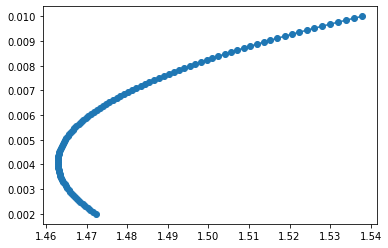

DB손해보험    5.27
메리츠화재    36.16
삼성화재     58.57
dtype: float64

In [170]:
returns = [r[0] for r in result]
variances = [r[2] for r in result]
weights = [r[1] for r in result]
plt.plot(variances, returns, '-o')
plt.show()
portfolio_min_variance = pd.Series(weights[np.argmin(variances)]*100, index=covariance_matrix.columns).T
portfolio_min_variance

In [171]:
lastday = sise_day['날짜'].max()
lastprice = sise_day.query('날짜 == @lastday').merge(code, on='코드', how='left')[['회사명', '종가']].set_index('회사명')['종가'][sise_day_series.columns]
stock_num = np.round((lastprice.max()/lastprice)*(portfolio_min_variance/portfolio_min_variance.max()), 0).astype(int)
stock_num

DB손해보험    0
메리츠화재     9
삼성화재      1
dtype: int32

In [172]:
sum(stock_num*lastprice)

384300.0

In [173]:
sum(stock_num*mean_returns*lastprice)

2035.5688534156739